In [1]:
# To write a Python 2/3 compatible codebase, the first step is to add this line to the top of each module
from __future__ import division, print_function, unicode_literals
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report
from sklearn.metrics import confusion_matrix
from IPython.display import Image
from sklearn.tree import export_graphviz
import os
from sklearn import tree
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV #http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.linear_model import LogisticRegression 
from sklearn import neighbors, datasets
from sklearn.preprocessing import StandardScaler


# Seed the generatpr to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# Model 1: Amazon Revenue Ranking

In [2]:
# load dataset
df = pd.read_csv("D:\\Intro to Business Analytics\\Team Project\\Kindle dataset_v6.csv") 
df = df.iloc[:,[3,8,9,10,11,12,13,14,15]]
df = df.dropna(axis=0, how='any')
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [3]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

#Normalize Data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Grid search

In [ ]:
#Choosing depth of the tree AND splitting criterion AND min_samples_leaf AND min_samples_split
gs_dt2 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [4, 5, 6, 7,8,9,10, None], 'criterion':['gini','entropy'], 
                              'min_samples_leaf':[11,22,33,44,55,66,77,88,99],
                              'min_samples_split':[2,3,4,5,15,35,99]}],
                  scoring='accuracy',
                  cv=10,
                  n_jobs=4)

gs_dt2 = gs_dt2.fit(X_train, y_train)
print(gs_dt2.best_score_)
print(gs_dt2.best_params_)

#Choosing C parameter for Logistic Regression AND type of penalty
gs_lr2 = GridSearchCV(estimator=LogisticRegression(random_state=0),
                  param_grid=[{'C': [ 0.00001, 0.0001, 0.001, 0.01, 0.1 ,1 ,10 ,100, 1000, 10000, 100000, 1000000, 10000000],
                             'penalty':['l1','l2']}],
                  scoring='accuracy',
                  cv=10)

gs_lr2 = gs_lr2.fit(X_train, y_train)
print(gs_lr2.best_score_)
print(gs_lr2.best_params_)

In [ ]:
#Choosing k for kNN AND type of distance

gs_knn2 = GridSearchCV(estimator=neighbors.KNeighborsClassifier(p=2, 
                           metric='minkowski',weights='distance'),
                  param_grid=[{'n_neighbors': [535,147,845,1245,256]}],
                  scoring='accuracy',
                  cv=10,
                  n_jobs=4)
gs_knn2 = gs_knn2.fit(X_train_std, y_train)          
print(gs_knn2.best_score_)
print(gs_knn2.best_params_)
print(gs_knn2.best_estimator_)

# Desicion Tree (Model1)

In [4]:
DT = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf=88, min_samples_split=2, random_state=0, criterion="entropy")
DT = DT.fit(X_train, y_train)

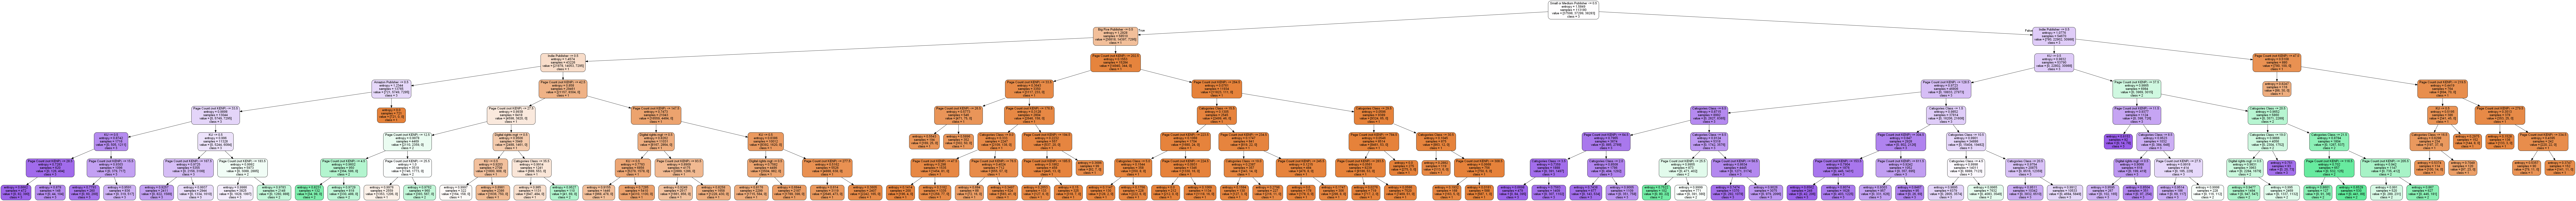

In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)
    
import graphviz 

export_graphviz(
        DT,
        out_file=image_path("DT.dot"),
        feature_names=list(X),
        class_names='123',
        rounded=True,
        filled=True
    )

#dot -Tpng DT.dot -o DT.png
path_png = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, "DT.png")
Image(path_png)

Confusion matrix, without normalization
[[24427   783     0]
 [ 4707  8953 11036]
 [    0  5586 19962]]
Normalized confusion matrix
[[ 0.97  0.03  0.  ]
 [ 0.19  0.36  0.45]
 [ 0.    0.22  0.78]]


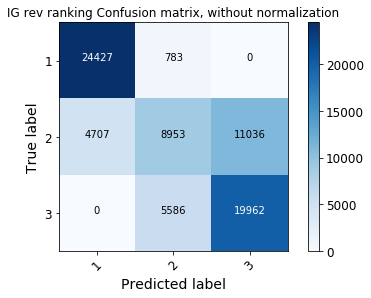

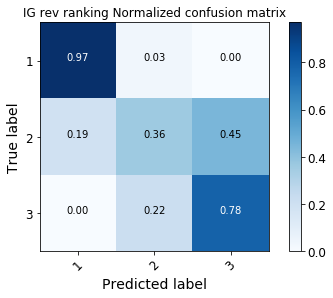

In [6]:
import itertools

y_pred_IG = DT.predict(X_test)

# Normalization can be applied by setting `normalize=True` (see below for examples)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #interpolation='nearest' simply display the image without try to interpolate betwen pixels if the display resolution is not the same as the image resolution
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
DT_matrix = confusion_matrix(y_test, y_pred_IG)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(DT_matrix, classes=list(np.unique(y)),
                      title='IG rev ranking Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(DT_matrix, classes=list(np.unique(y)), normalize=True,
                      title='IG rev ranking Normalized confusion matrix')

plt.show()

In [7]:
# Estimate the predicted values by applying the kNN algorithm
y_pred_IG = DT.predict(X_test)
y_pred_IG_insample = DT.predict(X_train)

# Accuracy
print('DT_Accuracy (out-of-sample): %.3f' % accuracy_score(y_test, y_pred_IG))
print('DT_Accuracy (in-sample): %.3f' % accuracy_score(y_train, y_pred_IG_insample))

# F1 score
print('DT_F1 score (out-of-sample): ', f1_score(y_test, y_pred_IG, average='macro'))
print('DT_F1 score (in-sample)    : ', f1_score(y_train, y_pred_IG_insample, average='macro'))

# Kappa score
print('DT_Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred_IG))
print('DT_Kappa score (in-sample)    : ', cohen_kappa_score(y_train, y_pred_IG_insample))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred_IG, target_names=None))

DT_Accuracy (out-of-sample): 0.707
DT_Accuracy (in-sample): 0.709
DT_F1 score (out-of-sample):  0.684156724102
DT_F1 score (in-sample)    :  0.687273000312
DT_Kappa score (out-of-sample):  0.559605410568
DT_Kappa score (in-sample)    :  0.562886666129
             precision    recall  f1-score   support

          1       0.84      0.97      0.90     25210
          2       0.58      0.36      0.45     24696
          3       0.64      0.78      0.71     25548

avg / total       0.69      0.71      0.69     75454



# KNN (Model1)

In [8]:
knn = neighbors.KNeighborsClassifier(n_neighbors=147, 
                                     weights="uniform",
                                     p=2, 
                                     metric='minkowski') 
knn = knn.fit(X_train_std, y_train) 
y_pred_knn=knn.predict(X_test_std)

Confusion matrix, without normalization
[[24447   763     0]
 [ 4813  9202 10681]
 [    0  5954 19594]]
Normalized confusion matrix
[[ 0.97  0.03  0.  ]
 [ 0.19  0.37  0.43]
 [ 0.    0.23  0.77]]


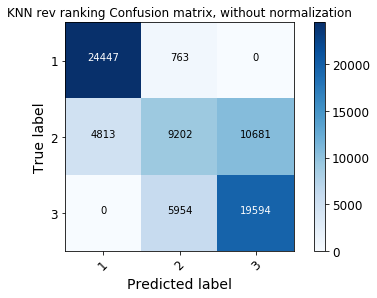

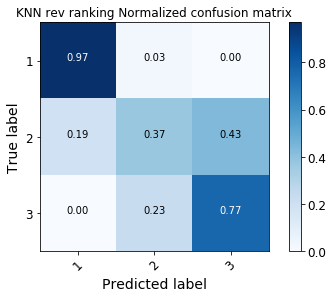

In [9]:
knn_matrix = confusion_matrix(y_test, y_pred_knn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(knn_matrix, classes=list(np.unique(y)),
                      title='KNN rev ranking Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(knn_matrix, classes=list(np.unique(y)), normalize=True,
                      title='KNN rev ranking Normalized confusion matrix')

plt.show()

In [10]:
# Estimate the predicted values by applying the kNN algorithm
y_pred_knn = knn.predict(X_test_std)
y_pred_knn_insample = knn.predict(X_train_std)

# Accuracy
print('knn_Accuracy (out-of-sample): %.3f' % accuracy_score(y_test, y_pred_knn))
print('knn_Accuracy (in-sample): %.3f' % accuracy_score(y_train, y_pred_knn_insample))

# F1 score
print('knn_F1 score (out-of-sample): ', f1_score(y_test, y_pred_knn, average='macro'))
print('knn_F1 score (in-sample)    : ', f1_score(y_train, y_pred_knn_insample, average='macro'))

# Kappa score
print('knn_Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred_knn))
print('knn_Kappa score (in-sample)    : ', cohen_kappa_score(y_train, y_pred_knn_insample))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred_knn, target_names=None))

knn_Accuracy (out-of-sample): 0.706
knn_Accuracy (in-sample): 0.711
knn_F1 score (out-of-sample):  0.684256450964
knn_F1 score (in-sample)    :  0.690398246808
knn_Kappa score (out-of-sample):  0.55769802825
knn_Kappa score (in-sample)    :  0.565586555952
             precision    recall  f1-score   support

          1       0.84      0.97      0.90     25210
          2       0.58      0.37      0.45     24696
          3       0.65      0.77      0.70     25548

avg / total       0.69      0.71      0.69     75454



# Logistic Regression (Model1)

In [11]:
LR = linear_model.LogisticRegression(C=0.1,penalty='l2',random_state=0)

LR = LR.fit(X_train, y_train)
y_predLR = LR.predict(X_test)

print('The weights of the attributes are:', LR.coef_)

The weights of the attributes are: [[  7.68e-03  -1.96e-01   1.54e-01   6.02e+00  -3.50e-01   7.19e+00
    8.74e+00   6.67e-04]
 [ -1.79e-04  -8.47e-02   3.00e-01  -8.07e-01   4.97e-02  -2.35e+00
   -3.25e+00  -1.55e-05]
 [ -2.78e-03   2.20e-01  -5.48e-01  -6.31e+00  -1.53e-01  -3.03e+00
   -6.09e+00  -3.15e-04]]


Confusion matrix, without normalization
[[25210     0     0]
 [ 5872  3785 15039]
 [    6  2763 22779]]
Normalized confusion matrix
[[  1.00e+00   0.00e+00   0.00e+00]
 [  2.38e-01   1.53e-01   6.09e-01]
 [  2.35e-04   1.08e-01   8.92e-01]]


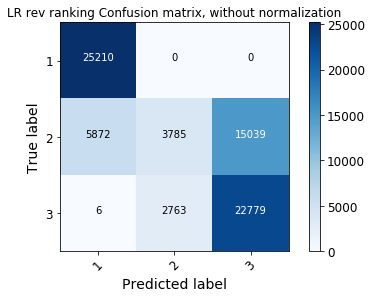

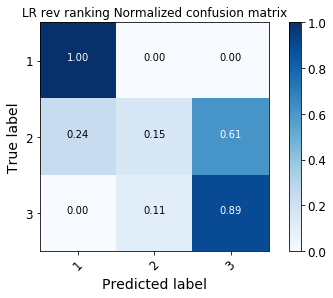

In [12]:
LR_matrix = confusion_matrix(y_test, y_predLR)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR_matrix, classes=list(np.unique(y)),
                      title='LR rev ranking Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR_matrix, classes=list(np.unique(y)), normalize=True,
                      title='LR rev ranking Normalized confusion matrix')

plt.show()

In [13]:
# Estimate the predicted values by applying the LR algorithm
y_pred_LR = LR.predict(X_test)
y_pred_LR_insample = LR.predict(X_train)

# Accuracy
print('LR_Accuracy (out-of-sample): %.3f' % accuracy_score(y_test, y_pred_LR))
print('LR_Accuracy (in-sample): %.3f' % accuracy_score(y_train, y_pred_LR_insample))

# F1 score
print('LR_F1 score (out-of-sample): ', f1_score(y_test, y_pred_LR, average='macro'))
print('LR_F1 score (in-sample)    : ', f1_score(y_train, y_pred_LR_insample, average='macro'))

# Kappa score
print('LR_Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred_LR))
print('LR_Kappa score (in-sample)    : ', cohen_kappa_score(y_train, y_pred_LR_insample))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred_LR, target_names=None))

LR_Accuracy (out-of-sample): 0.686
LR_Accuracy (in-sample): 0.683
LR_F1 score (out-of-sample):  0.618947947883
LR_F1 score (in-sample)    :  0.616830986502
LR_Kappa score (out-of-sample):  0.527526358027
LR_Kappa score (in-sample)    :  0.523288143531
             precision    recall  f1-score   support

          1       0.81      1.00      0.90     25210
          2       0.58      0.15      0.24     24696
          3       0.60      0.89      0.72     25548

avg / total       0.66      0.69      0.62     75454



# Model 2: customer rating

In [14]:
# load dataset
df = pd.read_csv("D:\\Intro to Business Analytics\\Team Project\\Kindle dataset_v6.csv") 
df = df.iloc[:,[16,4,5,8,9,10,11,12,13,14,15]]
df = df.dropna(axis=0, how='any')
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

#Normalize Data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Desicion Tree (Model2)

In [15]:
DT2 = tree.DecisionTreeClassifier(max_depth=8, min_samples_leaf=99, min_samples_split=2, random_state=0, criterion="gini")
DT2 = DT2.fit(X_train, y_train)

In [16]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)
    
import graphviz 

export_graphviz(
        DT2,
        out_file=image_path("DT.dot"),
        feature_names=list(X),
        class_names='123',
        rounded=True,
        filled=True
    )

#dot -Tpng DT_gini.dot -o DT_gini.png
path_png = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, "DT2.png")
Image(path_png)

IndexError: string index out of range

Confusion matrix, without normalization
[[16588     0     0     0     1     4]
 [    0    22     0    34   141   538]
 [    0     5     0    43   634   423]
 [    0    10     0   209  6638  1126]
 [    2    12     0   152 37846  2262]
 [    0    19     0    76  3686  4983]]
Normalized confusion matrix
[[  1.00e+00   0.00e+00   0.00e+00   0.00e+00   6.03e-05   2.41e-04]
 [  0.00e+00   2.99e-02   0.00e+00   4.63e-02   1.92e-01   7.32e-01]
 [  0.00e+00   4.52e-03   0.00e+00   3.89e-02   5.74e-01   3.83e-01]
 [  0.00e+00   1.25e-03   0.00e+00   2.62e-02   8.32e-01   1.41e-01]
 [  4.97e-05   2.98e-04   0.00e+00   3.77e-03   9.40e-01   5.62e-02]
 [  0.00e+00   2.17e-03   0.00e+00   8.67e-03   4.21e-01   5.69e-01]]


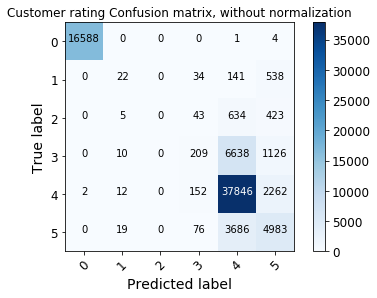

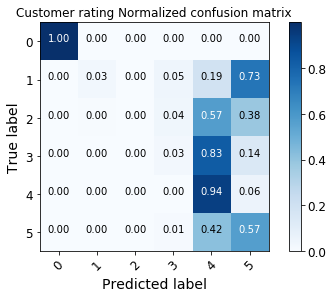

In [17]:
import itertools

y_pred_gini = DT2.predict(X_test)

# Normalization can be applied by setting `normalize=True` (see below for examples)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #interpolation='nearest' simply display the image without try to interpolate betwen pixels if the display resolution is not the same as the image resolution
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
DT_matrix = confusion_matrix(y_test, y_pred_gini)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(DT_matrix, classes=list(np.unique(y)),
                      title='Customer rating Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(DT_matrix, classes=list(np.unique(y)), normalize=True,
                      title='Customer rating Normalized confusion matrix')

plt.show()

In [18]:
# Estimate the predicted values by applying the kNN algorithm
y_pred_gini = DT2.predict(X_test)
y_pred_gini_insample = DT2.predict(X_train)

# Accuracy
print('DT_Accuracy (out-of-sample): %.3f' % accuracy_score(y_test, y_pred_gini))
print('DT_Accuracy (in-sample): %.3f' % accuracy_score(y_train, y_pred_gini_insample))

# F1 score
print('DT_F1 score (out-of-sample): ', f1_score(y_test, y_pred_gini, average='macro'))
print('DT_F1 score (in-sample)    : ', f1_score(y_train, y_pred_gini_insample, average='macro'))

# Kappa score
print('DT_Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred_gini))
print('DT_Kappa score (in-sample)    : ', cohen_kappa_score(y_train, y_pred_gini_insample))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred_gini, target_names=None))

DT_Accuracy (out-of-sample): 0.791
DT_Accuracy (in-sample): 0.791
DT_F1 score (out-of-sample):  0.417126656823
DT_F1 score (in-sample)    :  0.42327067051
DT_Kappa score (out-of-sample):  0.645136626594


C:\Users\lancy\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\lancy\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


DT_Kappa score (in-sample)    :  0.647133280623
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     16593
          1       0.32      0.03      0.05       735
          2       0.00      0.00      0.00      1105
          3       0.41      0.03      0.05      7983
          4       0.77      0.94      0.85     40274
          5       0.53      0.57      0.55      8764

avg / total       0.74      0.79      0.74     75454



# KNN (Model2)

In [19]:
knn2 = neighbors.KNeighborsClassifier(n_neighbors=535, 
                                     weights="distance",
                                     p=2, 
                                     metric='minkowski') 
knn2 = knn2.fit(X_train_std, y_train) 
y_pred_knn2=knn2.predict(X_test_std)

Confusion matrix, without normalization
[[ 8267     1     1     2  8294    28]
 [  312    23     6    12   354    28]
 [  343     9     9    28   691    25]
 [ 1043    14    19   257  6574    76]
 [ 2607    12    33   215 37215   192]
 [ 1885    31    28    86  6434   300]]
Normalized confusion matrix
[[  4.98e-01   6.03e-05   6.03e-05   1.21e-04   5.00e-01   1.69e-03]
 [  4.24e-01   3.13e-02   8.16e-03   1.63e-02   4.82e-01   3.81e-02]
 [  3.10e-01   8.14e-03   8.14e-03   2.53e-02   6.25e-01   2.26e-02]
 [  1.31e-01   1.75e-03   2.38e-03   3.22e-02   8.23e-01   9.52e-03]
 [  6.47e-02   2.98e-04   8.19e-04   5.34e-03   9.24e-01   4.77e-03]
 [  2.15e-01   3.54e-03   3.19e-03   9.81e-03   7.34e-01   3.42e-02]]


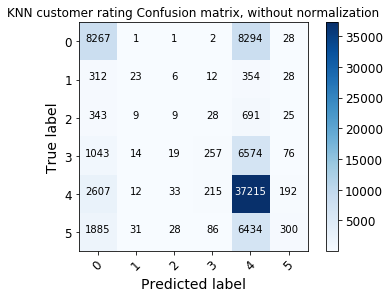

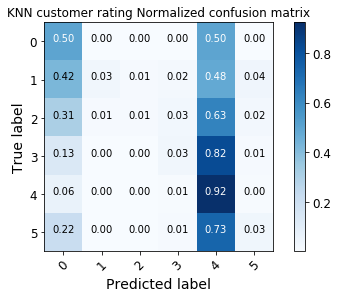

In [20]:
knn_matrix = confusion_matrix(y_test, y_pred_knn2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(knn_matrix, classes=list(np.unique(y)),
                      title='KNN customer rating Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(knn_matrix, classes=list(np.unique(y)), normalize=True,
                      title='KNN customer rating Normalized confusion matrix')

plt.show()

In [21]:
# Estimate the predicted values by applying the kNN algorithm
y_pred_knn2 = knn2.predict(X_test_std)
y_pred_knn2_insample = knn2.predict(X_train_std)

# Accuracy
print('knn_Accuracy (out-of-sample): %.3f' % accuracy_score(y_test, y_pred_knn2))
print('knn_Accuracy (in-sample): %.3f' % accuracy_score(y_train, y_pred_knn2_insample))

# F1 score
print('knn_F1 score (out-of-sample): ', f1_score(y_test, y_pred_knn2, average='macro'))
print('knn_F1 score (in-sample)    : ', f1_score(y_train, y_pred_knn2_insample, average='macro'))

# Kappa score
print('knn_Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred_knn2))
print('knn_Kappa score (in-sample)    : ', cohen_kappa_score(y_train, y_pred_knn2_insample))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred_knn2, target_names=None))

knn_Accuracy (out-of-sample): 0.611
knn_Accuracy (in-sample): 0.992
knn_F1 score (out-of-sample):  0.245398528713
knn_F1 score (in-sample)    :  0.979328981448
knn_Kappa score (out-of-sample):  0.271653806195
knn_Kappa score (in-sample)    :  0.987357473311
             precision    recall  f1-score   support

          0       0.57      0.50      0.53     16593
          1       0.26      0.03      0.06       735
          2       0.09      0.01      0.01      1105
          3       0.43      0.03      0.06      7983
          4       0.62      0.92      0.75     40274
          5       0.46      0.03      0.06      8764

avg / total       0.56      0.61      0.53     75454



# Logistic Regression (Model2)

In [22]:
LR2 = linear_model.LogisticRegression(C=0.1,penalty='l2',random_state=0)

LR2 = LR2.fit(X_train, y_train)
y_predLR2 = LR2.predict(X_test)

print('The weights of the attributes are:', LR2.coef_)

The weights of the attributes are: [[ -4.44e-04  -8.80e+00   1.62e-02   7.42e-01   6.41e-01   6.67e-01
    6.74e-01   5.11e-03   2.27e-01   1.77e-04]
 [ -2.22e-03  -6.48e-02   3.93e-03  -1.47e-01  -1.13e-01   4.02e-01
   -6.05e-01  -2.60e-02  -1.10e+00  -6.44e-04]
 [ -4.11e-03  -3.66e-03  -4.94e-05  -1.17e-01   1.75e-01   3.84e-01
   -1.96e-01  -9.63e-02  -4.08e-01   1.83e-05]
 [ -3.40e-03   4.99e-07   2.39e-03  -3.70e-02   1.87e-01   3.12e-01
    2.51e-01   3.80e-01   4.33e-01   3.63e-05]
 [ -9.77e-03   7.81e-03  -9.56e-03   3.08e-02   1.83e-02   2.14e-02
    5.58e-01   4.41e-01   1.11e+00   2.87e-04]
 [  1.36e-03  -6.82e-02  -8.83e-03  -5.42e-02   3.22e-03  -2.27e-01
   -1.23e-01  -4.92e-02  -2.61e-01   6.27e-06]]


Confusion matrix, without normalization
[[16588     0     0     0     5     0]
 [    0     0     0     0   732     3]
 [    0     0     0     0  1103     2]
 [    0     0     0     0  7974     9]
 [    2     0     0     0 40240    32]
 [    0     0     0     0  8698    66]]
Normalized confusion matrix
[[  1.00e+00   0.00e+00   0.00e+00   0.00e+00   3.01e-04   0.00e+00]
 [  0.00e+00   0.00e+00   0.00e+00   0.00e+00   9.96e-01   4.08e-03]
 [  0.00e+00   0.00e+00   0.00e+00   0.00e+00   9.98e-01   1.81e-03]
 [  0.00e+00   0.00e+00   0.00e+00   0.00e+00   9.99e-01   1.13e-03]
 [  4.97e-05   0.00e+00   0.00e+00   0.00e+00   9.99e-01   7.95e-04]
 [  0.00e+00   0.00e+00   0.00e+00   0.00e+00   9.92e-01   7.53e-03]]


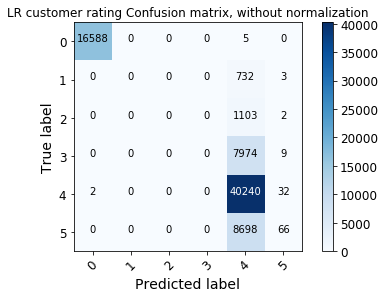

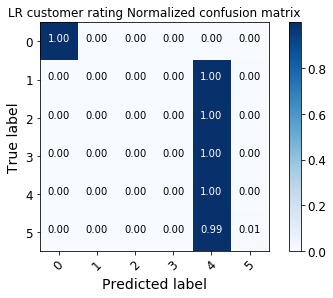

In [23]:
LR_matrix = confusion_matrix(y_test, y_predLR2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR_matrix, classes=list(np.unique(y)),
                      title='LR customer rating Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR_matrix, classes=list(np.unique(y)), normalize=True,
                      title='LR customer rating Normalized confusion matrix')

plt.show()

In [24]:
# Estimate the predicted values by applying the LR algorithm
y_pred_LR2 = LR2.predict(X_test)
y_pred_LR2_insample = LR2.predict(X_train)

# Accuracy
print('LR_Accuracy (out-of-sample): %.3f' % accuracy_score(y_test, y_pred_LR2))
print('LR_Accuracy (in-sample): %.3f' % accuracy_score(y_train, y_pred_LR2_insample))

# F1 score
print('LR_F1 score (out-of-sample): ', f1_score(y_test, y_pred_LR2, average='macro'))
print('LR_F1 score (in-sample)    : ', f1_score(y_train, y_pred_LR2_insample, average='macro'))

# Kappa score
print('LR_Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred_LR2))
print('LR_Kappa score (in-sample)    : ', cohen_kappa_score(y_train, y_pred_LR2_insample))

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, y_pred_LR2, target_names=None))

LR_Accuracy (out-of-sample): 0.754
LR_Accuracy (in-sample): 0.751
LR_F1 score (out-of-sample):  0.30456274413
LR_F1 score (in-sample)    :  0.303701538428
LR_Kappa score (out-of-sample):  0.540974584671
LR_Kappa score (in-sample)    :  -0.239016112422
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     16593
          1       0.00      0.00      0.00       735
          2       0.00      0.00      0.00      1105
          3       0.00      0.00      0.00      7983
          4       0.68      1.00      0.81     40274
          5       0.59      0.01      0.01      8764

avg / total       0.65      0.75      0.66     75454



C:\Users\lancy\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\lancy\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# prediction

In [25]:
data1 = np.array([['','Catogories Class', 'Digital rights mgt', 'KU', 'Indie Publisher', 
                   'Small or Medium Publisher', 'Amazon Publsher', 'Big Five Publisher', 'Page Count (not KENP)'],
               
                ['1',3,0,0,1,0,0,0,40]])
                
predictdf1 = pd.DataFrame(data=data1[1:,1:],
                  index=data1[1:,0],
                  columns=data1[0,1:])

In [26]:
print("predict Amazon Rev Ranking using DT",DT.predict(predictdf1.iloc[:1,:]))

predict Amazon Rev Ranking using DT [1]
